# Hello Bluesky: Reading detectors and scanning

In this notebook you will:

* Connect to some simulated hardware.
* Acquire some data via two common experimental procedures ("plans"), ``count`` and ``scan``.
* Write a custom plan.

Recommend Prerequisites:

* [Hello Python and Jupyter](./Hello%20Python%20and%20Jupyter.ipynb)

## Configuration
Below, we will connect to EPICS IOC(s) controlling simulated hardware in lieu of actual motors and detectors. An EPICS IOC is control system software that allows communication with a wide variety of hardware using a common interface. The IOCs should already be running in the background. Run this command to verify that they are running: it should produce output with RUNNING on each line. In the event of a problem, edit this command to replace `status` with `restart all` and run again.

In [1]:
%matplotlib widget

In [2]:
!supervisorctl -c supervisor/supervisord.conf status

decay                            RUNNING   pid 4868, uptime 0:01:24
mini_beamline                    RUNNING   pid 4869, uptime 0:01:24
random_walk                      RUNNING   pid 4870, uptime 0:01:24
random_walk_horiz                RUNNING   pid 4871, uptime 0:01:24
random_walk_vert                 RUNNING   pid 4872, uptime 0:01:24
simple                           RUNNING   pid 4873, uptime 0:01:24
thermo_sim                       RUNNING   pid 4874, uptime 0:01:24
trigger_with_pc                  RUNNING   pid 4875, uptime 0:01:24


In [3]:
%run scripts/beamline_configuration.py

In [4]:
# aliases for convenience/readability
motor = motor_ph
det = ph

Check that we can communicate with the hardware. If this doesn't raise an error, it worked.

In [5]:
det.wait_for_connection()

## Data Acquisition

### Executing a `count` plan with various parameters

In the example below, the Bluesky run engine is the interpreter of experiment plans and `count` is an experiment plan used here to acquire one reading from a point detector.

In [6]:
from bluesky.plans import count
RE(count([det]))



Transient Scan ID: 6     Time: 2020-06-17 20:20:25
Persistent Unique Scan ID: '0cd5e624-3d9d-4496-97d6-15e32337cdc6'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:20:25.1 |      97837 |
+-----------+------------+------------+
generator count ['0cd5e624'] (scan num: 6)





('0cd5e624-3d9d-4496-97d6-15e32337cdc6',)

The return value is a list of the run IDs that uniquely identify this data set. The "scan num" is easier to remember but is not good for long-term reference because it may not be unique.

Let's looks at the documentation for `count` to see what our other options are.

In [7]:
help(count)  # or, equiavently, type count? or ?count

Help on function count in module bluesky.plans:

count(detectors, num=1, delay=None, *, per_shot=None, md=None)
    Take one or more readings from detectors.
    
    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    num : integer, optional
        number of readings to take; default is 1
    
        If None, capture data until canceled
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.
    per_shot : callable, optional
        hook for customizing action of inner loop (messages per step)
        Expected signature ::
    
           def f(detectors: Iterable[OphydObj]) -> Generator[Msg]:
               ...
    
    md : dict, optional
        metadata
    
    Notes
    -----
    If ``delay`` is an iterable, it must have at least ``num - 1`` entries or
    the plan will raise a ``ValueError`` during iteration.



In [8]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs time')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [9]:
# five consecutive readings
RE(count([det], num=5))



Transient Scan ID: 7     Time: 2020-06-17 20:20:25
Persistent Unique Scan ID: 'f97be935-c70e-4a9e-b443-d3f716be1e54'
New stream: 'primary'


+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:20:25.4 |      99538 |
|         2 | 20:20:25.4 |      99907 |
|         3 | 20:20:25.4 |      99812 |
|         4 | 20:20:25.4 |      99759 |
|         5 | 20:20:25.4 |     100175 |


+-----------+------------+------------+
generator count ['f97be935'] (scan num: 7)





('f97be935-c70e-4a9e-b443-d3f716be1e54',)

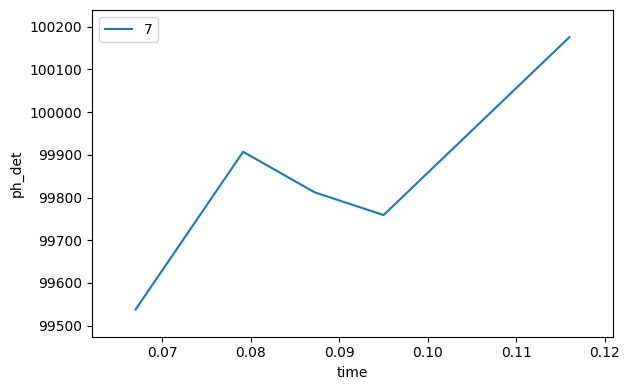

In [10]:
plt.gcf()  # Display a snapshot of the current state of the figure.

In [11]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
# five sequential readings separated by a 1-second delay
RE(count([det], num=5, delay=1))



Transient Scan ID: 8     Time: 2020-06-17 20:20:25
Persistent Unique Scan ID: '06cc93b6-72f4-4f3b-b665-51bf589d7527'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |     ph_det |
+-----------+------------+------------+
|         1 | 20:20:25.9 |     102962 |


|         2 | 20:20:26.9 |      98817 |


|         3 | 20:20:27.9 |      93067 |


|         4 | 20:20:28.9 |      96592 |


|         5 | 20:20:29.9 |     103285 |


+-----------+------------+------------+
generator count ['06cc93b6'] (scan num: 8)





('06cc93b6-72f4-4f3b-b665-51bf589d7527',)

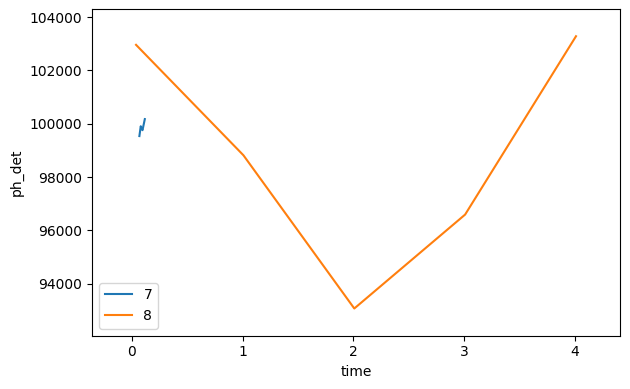

In [13]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Scan

Scan ``motor`` from -10 to 10, stopping at 15 equally-spaced points along the way and reading ``det``.

In [14]:
# Creating a figure explicitly in advance helps with the
# top-to-bottom flow of this notebook, but it is not necessary.
# If this is omitted, bluesky will cause a figure to appear
# during the RE(...) execution below.
plt.figure('ph_det vs motor_ph')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<Figure size 640x480 with 0 Axes>

In [15]:
RE(scan([det], motor, -10, 10, 15))



Transient Scan ID: 9     Time: 2020-06-17 20:20:31
Persistent Unique Scan ID: '8feebc81-ecab-4a37-b2eb-50eb9bbfbce4'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:20:31.6 |    -10.000 |      13137 |
|         2 | 20:20:31.7 |     -8.571 |      22153 |
|         3 | 20:20:31.7 |     -7.143 |      34840 |
|         4 | 20:20:31.7 |     -5.714 |      50276 |
|         5 | 20:20:31.7 |     -4.286 |      66273 |
|         6 | 20:20:31.8 |     -2.857 |      81122 |


|         7 | 20:20:31.8 |     -1.429 |      91970 |
|         8 | 20:20:31.8 |      0.000 |      95074 |
|         9 | 20:20:31.8 |      1.429 |      91194 |
|        10 | 20:20:31.8 |      2.857 |      81212 |
|        11 | 20:20:31.8 |      4.286 |      66668 |
|        12 | 20:20:31.8 |      5.714 |      49458 |
|        13 | 20:20:31.9 |      7.143 |      34585 |
|        14 | 20:20:31.9 |      8.571 |      21817 |
|        15 | 20:20:31.9 |     10.000 |      12902 |
+-----------+------------+------------+------------+
generator scan ['8feebc81'] (scan num: 9)





('8feebc81-ecab-4a37-b2eb-50eb9bbfbce4',)

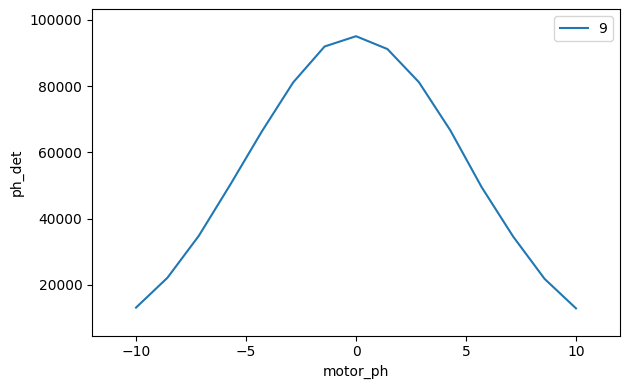

In [16]:
plt.gcf()  # Display a snapshot of the current state of the figure.

### Simulators

Bluesky includes utilities to inspecting plans before they are run. You can imagine various reasons you might want to do this. Example:

In [17]:
from bluesky.simulators import summarize_plan

summarize_plan(scan([det], motor, -1, 1, 3))

=================================== Open Run ===================================
motor_ph -> -1.0
  Read ['ph', 'motor_ph']
motor_ph -> 0.0
  Read ['ph', 'motor_ph']
motor_ph -> 1.0
  Read ['ph', 'motor_ph']
================================== Close Run ===================================


### Custom plan

Define a custom "plan", using the Python syntax ``yield from`` to dispatch out to built-in plans.

In [18]:
plt.gcf().canvas  # To avoid needing to scroll up, display the interactive canvas again here.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
# The plan_stubs module contains smaller plans.
# They can be used alone or as buildling blocks for larger plans.
from bluesky.plan_stubs import mv


def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        yield from mv(det.exp, t)
        yield from scan([det], motor, -10, 10, 5)
        
RE(sweep_exposure_time([0.01, 0.1, 1]))



Transient Scan ID: 10     Time: 2020-06-17 20:20:32
Persistent Unique Scan ID: '49cd9a44-cfba-489e-aa67-1928af3b06a3'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:20:32.8 |    -10.000 |        114 |
|         2 | 20:20:32.9 |     -5.000 |        579 |


|         3 | 20:20:33.0 |      0.000 |        976 |
|         4 | 20:20:33.2 |      5.000 |        607 |


|         5 | 20:20:33.3 |     10.000 |        159 |
+-----------+------------+------------+------------+
generator scan ['49cd9a44'] (scan num: 10)





Transient Scan ID: 11     Time: 2020-06-17 20:20:33
Persistent Unique Scan ID: '43fc181d-cb3b-490e-b855-ae39412a34b9'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:20:33.8 |    -10.000 |       1418 |
|         2 | 20:20:34.0 |     -5.000 |       6386 |


|         3 | 20:20:34.1 |      0.000 |      10493 |
|         4 | 20:20:34.2 |      5.000 |       6233 |


|         5 | 20:20:34.4 |     10.000 |       1441 |
+-----------+------------+------------+------------+
generator scan ['43fc181d'] (scan num: 11)





Transient Scan ID: 12     Time: 2020-06-17 20:20:34
Persistent Unique Scan ID: '25b94eec-4fa5-40c3-a0e9-ecb4eb3c974d'


New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |   motor_ph |     ph_det |
+-----------+------------+------------+------------+
|         1 | 20:20:34.9 |    -10.000 |      13879 |
|         2 | 20:20:35.0 |     -5.000 |      61168 |


|         3 | 20:20:35.1 |      0.000 |      99600 |
|         4 | 20:20:35.3 |      5.000 |      60199 |


|         5 | 20:20:35.4 |     10.000 |      13188 |
+-----------+------------+------------+------------+
generator scan ['25b94eec'] (scan num: 12)





('49cd9a44-cfba-489e-aa67-1928af3b06a3',
 '43fc181d-cb3b-490e-b855-ae39412a34b9',
 '25b94eec-4fa5-40c3-a0e9-ecb4eb3c974d')

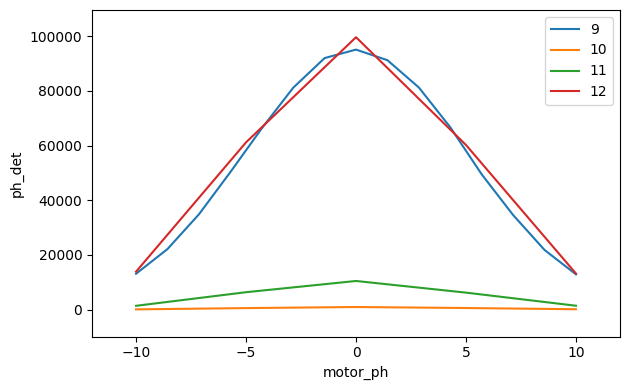

In [20]:
plt.gcf()  # Display a snapshot of the current state of the figure.

## Exercises

Q1: Above we ran a `count` with multiple readings separated by a fixed delay. The ``delay`` parameter also accepts a list of values. Try a `count` with a variable delay.


In [21]:
# Try your solution here. Fill in the blank:
# RE(count(____)))

Execute the following cell to reveal a solution:

In [22]:
%load solutions/count_variable_delay.py

Q2: Write a custom plan that scans the same region twice, first with coarse steps and then with fine steps.

In [23]:
# Try your solution here. Fill in the blank:
# def coarse_and_fine(detectors, motor, start, stop):
#     yield from scan(___)
#     yield from scan(___)
#
# RE(coarse_and_fine([det], motor, -10, 10))

In [24]:
%load solutions/scan_coarse_and_fine.py

Q3. All of the usages of scan we have seen so far scan from negative to positive. Scan from positive to negative.

In [25]:
# Try your solution here.

In [26]:
%load solutions/scan_positive_to_negative.py

Q4: The ``scan`` plan samples equally-spaced points. To sample *arbitrary* points, you can use ``list_scan``. Import it from the same module that we imported ``scan`` from, then use ``list_scan?`` to view its documentation and figure out how to use it. Scan the positions ``[1, 1, 2, 3, 5, 8]``.

In [27]:
# Try your solution here.

In [28]:
%load solutions/scan_fibonacci.py

Q5: What's wrong with this? (What does it do?)

In [29]:
# Broken example
def sweep_exposure_time(times):
    "Multiple scans: one per exposure time setting."
    for t in times:
        mv(det.exp, t)
        scan([det], motor, -10, 10, 15)

In [30]:
%load solutions/broken_sweep_exposure_time_explanation.txt